# Chess Piece Values by ML

A standard rule of thumb one learns when beginning chess is the so-called piece value rule. Namely, this rule says that a pawn is worth 1 point, a knight and bishop 3, a rook 5 and a queen 9 points. So, one should not exchange a queen for a rook for example, because they loose points: we gain 5 points but lose 9, so we end up with +5 - 9 = -4.

![img](board.PNG "Title")

But, where does this rule come from? In this notebook, we will try to give a "data analysis" approach on this question: Namely, we will use Machine Learning to estimate the piece values!

# The Idea

The idea is to interpret the chess piece values rule as a kind of predictor for the game’s outcome. That is, our surplus or shortage in a piece is a feature that can predict the game’s result (win, loss or draw). 

Specifically, our features are the following:

1. Our surplus (or shortage) of pawns.
2. Our surplus (or shortage) of knights.
3. Our surplus (or shortage) of bishops.
4. Our surplus (or shortage) of rooks.
5. Our surplus (or shortage) of queens.

Also, the outcome we want to predict is the following:

6. Game result (win, loss or draw).

We can also interpret this as predicting our winning probability.

Now, since the rule tells us to add the points for each piece, that means that we’re looking for a linear model, because linear models are exactly the kind of models where features are multiplied by their weights and added. In this light, piece values are exactly the weights of the above features!

With that, we can now begin our analysis!

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sklearn
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# other
import utils

# Dataset

Our data come from the lichess website (lichess.org). For every month, lichess publishes a database with games played on the website (https://database.lichess.org/). These databases contain a series of games stored in the PNG format. This is a format for chess game annotation, that provides the game moves, as well as additional information such as the game’s outcome, player’s ELO scores, game time controls, and more. An example of a PNG file can be seen below:

[Event "Rated Bullet tournament https://lichess.org/tournament/yc1WW2Ox"] <br>
[Site "https://lichess.org/PpwPOZMq"] <br>
[Date "2017.04.01"] <br>
[Round "-"] <br>
[White "Abbot"] <br>
[Black "Costello"] <br>
[Result "0-1"] <br>
[UTCDate "2017.04.01"] <br>
[UTCTime "11:32:01"] <br>
[WhiteElo "2100"] <br>
[BlackElo "2000"] <br>
[WhiteRatingDiff "-4"] <br>
[BlackRatingDiff "+1"] <br>
[WhiteTitle "FM"] <br>
[ECO "B30"] <br>
[Opening "Sicilian Defense: Old Sicilian"] <br>
[TimeControl "300+0"] <br>
[Termination "Time forfeit"] <br>
 <br>
1. e4 { [%eval 0.17] [%clk 0:00:30] } 1... c5 { [%eval 0.19] [%clk 0:00:30] } <br>
2. Nf3 { [%eval 0.25] [%clk 0:00:29] } 2... Nc6 { [%eval 0.33] [%clk 0:00:30] } <br>
3. Bc4 { [%eval -0.13] [%clk 0:00:28] } 3... e6 { [%eval -0.04] [%clk 0:00:30] } <br>
4. c3 { [%eval -0.4] [%clk 0:00:27] } 4... b5? { [%eval 1.18] [%clk 0:00:30] } <br>
5. Bb3?! { [%eval 0.21] [%clk 0:00:26] } 5... c4 { [%eval 0.32] [%clk 0:00:29] } <br>
6. Bc2 { [%eval 0.2] [%clk 0:00:25] } 6... a5 { [%eval 0.6] [%clk 0:00:29] } <br>
7. d4 { [%eval 0.29] [%clk 0:00:23] } 7... cxd3 { [%eval 0.6] [%clk 0:00:27] } <br>
8. Qxd3 { [%eval 0.12] [%clk 0:00:22] } 8... Nf6 { [%eval 0.52] [%clk 0:00:26] } <br>
9. e5 { [%eval 0.39] [%clk 0:00:21] } 9... Nd5 { [%eval 0.45] [%clk 0:00:25] } <br>
10. Bg5?! { [%eval -0.44] [%clk 0:00:18] } 10... Qc7 { [%eval -0.12] [%clk 0:00:23] } <br>
11. Nbd2?? { [%eval -3.15] [%clk 0:00:14] } 11... h6 { [%eval -2.99] [%clk 0:00:23] } <br>
12. Bh4 { [%eval -3.0] [%clk 0:00:11] } 12... Ba6? { [%eval -0.12] [%clk 0:00:23] } <br>
13. b3?? { [%eval -4.14] [%clk 0:00:02] } 13... Nf4? { [%eval -2.73] [%clk 0:00:21] } 0-1

From this, what we need to get is some vectors with the piece differences at some specific positions. Such a vector will look like this: <br>
<code>vec_material = [pawn_diff, knight_diff, bishop_diff, rook_diff, queen_diff]</code>

We will do that in the following way:

1. We parse the games from the database.
2. For each game, we find some characteristic positions with material imbalances.
3. For these positions, we calculate the material imbalance vectors, and append them in our dataset (X)
4. For each one of those positions, our target is the game outcome: +1 for white’s win, -1 for black’s win, and 0 for draw. We store the outcomes in our target labels Y.

This is our final dataset. The process of the game parsing and their replay for position extraction is done using the functions of the utils.py script. There, we take some additional parameters into consideration: for example, if a game has issues like a big elo difference between players, very low game times, etc., then we exclude these games from the dataset, since they might have a negative influence on the results. 

Finally, some technical notes: to simplify the analysis, we will look at games from white’s perspective. That means, the material imbalances will be computed with respect to the white player: if white has an extra knight, then $knight-diff = 1$, while if black has an extra knight, then $knight-diff = -1$. Moreover, at some points we will convert the game outcomes in probabilities: 1 for white’s win, 0 for white’s loss, ½ for draw (we also see the outcome from white’s perspective).

First, we need to download the data. You can get it from here:
https://database.lichess.org/lichess_db_standard_rated_2013-01.pgn.bz2
After downloading is complete, extract the files in the same directory as this notebook (or change the path below).
After this is done, we can read the data:

In [4]:
# read data. This will take some time..
X, Y = utils.read_games('lichess_db_standard_rated_2013-01.pgn', skip_draws = True)

In [5]:
# save the data in numpy format
np.savez('positions_data', X = X, Y = Y)
# load data from npz
#dat = np.load('positions_data.npz')
#X = dat['X']
#Y = dat['Y']

Lets print some info for our data:

In [6]:
target_col = 5
dset_names = ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff', 'outcome']
print('Number of samples in dataset:', len(Y))
print('Input attributes:', dset_names[:target_col])
print('Target attribute:', dset_names[target_col])

print('sample inputs:')
print(X[:5])

print('sample outputs:')
print(Y[:5])

Number of samples in dataset: 13864
Input attributes: ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
Target attribute: outcome
sample inputs:
[[-1  1  0  0 -1]
 [ 0  1 -1  0  0]
 [-1  0 -1  0  1]
 [ 0  1 -1  0  0]
 [ 0  0 -1  1  0]]
sample outputs:
[-1  1  1  1 -1]


In [7]:
# make also a pandas dataframe
XY = np.hstack( (X, Y.reshape((len(Y), -1))) )
dataset = pd.DataFrame(XY, columns = dset_names)

# Data Exploration

In this section, we will plot some diagrams and try to get a visual overview of our data.

First, we make a boxplot of the various dataset features, to check their value ranges:

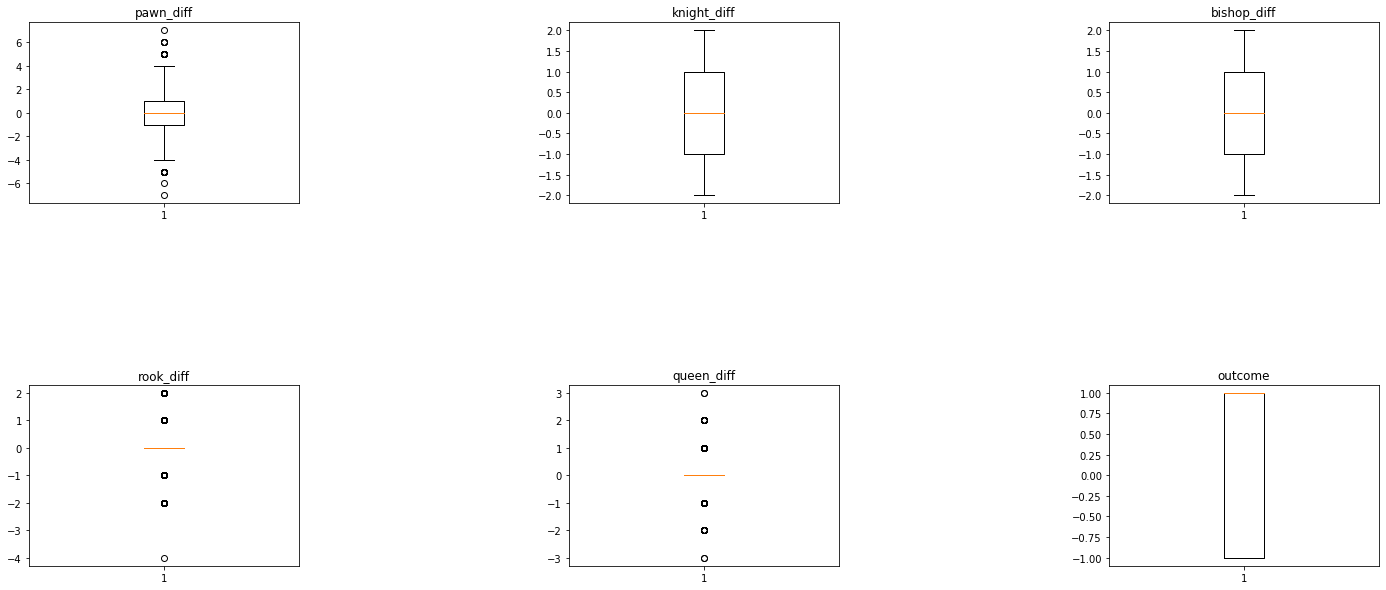

In [8]:
# adjust spacing between subplots
plt.figure(figsize = (10, 10))
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=1, hspace=1)

for i in range(len(dset_names)):
    plt.subplot(2, 3, i + 1)
    plt.boxplot(dataset[dset_names[i]])
    plt.gca().set_title(dset_names[i])
plt.show()

We see that our games are balanced on average, which is a good sign.

We can also plot the target variable with respect to each feature.

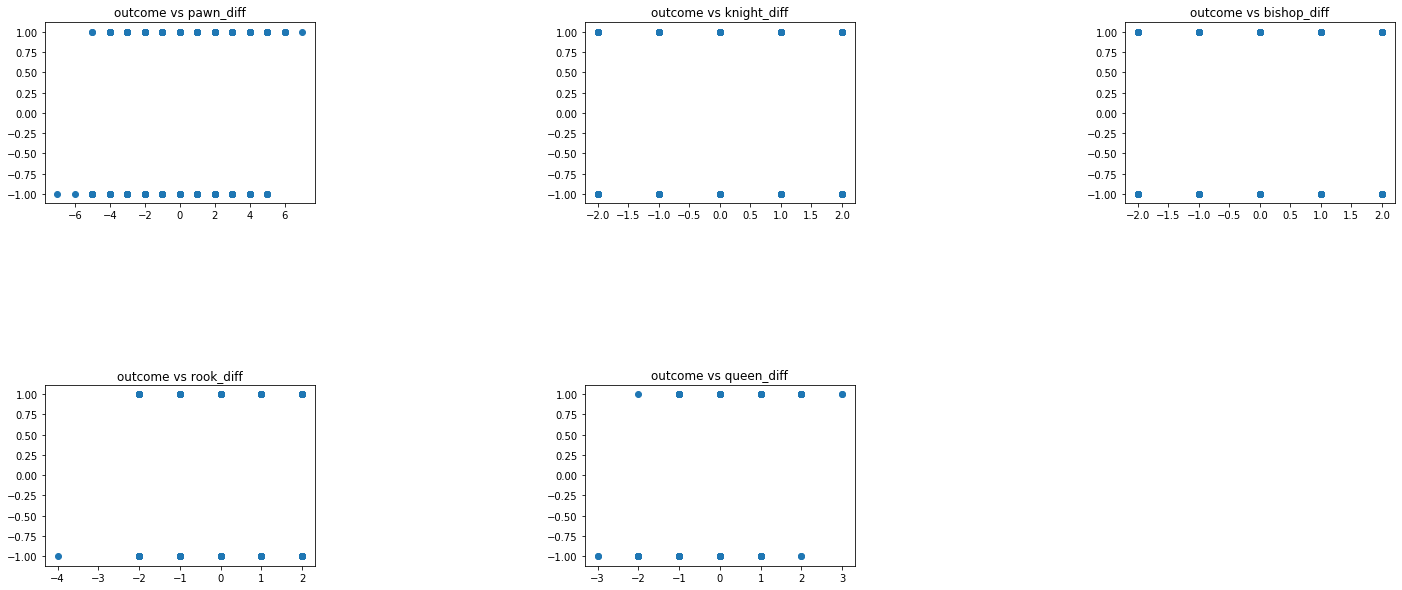

In [9]:
# adjust spacing between subplots
plt.figure(figsize = (10, 10))
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=1, hspace=1)

for i in range(len(dset_names) - 1):
    plt.subplot(2, 3, i + 1)
    plt.scatter(dataset[dset_names[i]], dataset[dset_names[-1]])
    plt.gca().set_title('outcome vs ' + dset_names[i])
plt.show()

We observe that individual material differences are not very informative, unless they’re very large.

# Train - Test Split

We spit our dataset in train and test. We will keep 70% of the data for training, and the rest for testing.

In [10]:
# Split our data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3)

# Model Training

Here, its time to train some (linear) models on our training set! 

### Logistic Regression

First, we will train a logistic regression. We excluded draws in this case, so we predict 2 categories: win or loss (binary classification).

In [11]:
clf = linear_model.LogisticRegression()

Train the model. We test different regularization strengths via grid search.

In [12]:
# grid parameters to test
Cs = [0.1, 0.5, 1, 2, 5]

estimator = GridSearchCV(clf, dict(C = Cs), cv=5, scoring='accuracy', n_jobs=-1)

# fit model
estimator.fit(Xtrain, Ytrain)
Ypred = estimator.predict(Xtest)

print('model trained')

model trained


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
print(estimator.best_estimator_)
print(estimator.best_params_)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 2}


Let’s check its performance on predicting game outcomes:

In [14]:
# peformance on training set
Ypred = estimator.predict(Xtrain)
acc_train = accuracy_score(Ypred, Ytrain)

# peformance on test set
Ypred = estimator.predict(Xtest)
acc_test = accuracy_score(Ypred, Ytest)

# print results
print('Performance on training set: ', 'acc = ', acc_train)
print('Performance on test set: ', 'acc = ', acc_test)

Performance on training set:  acc =  0.6856966199505359
Performance on test set:  acc =  0.6860576923076923


We see that performance is relatively low. This is expected, due to various factors. First, apart from material, here are many more features in chess that are important, such as the piece positions, etc. The piece value rule is a rule of thumb, not an absolute truth. Secondly, it might be the case that our method for selecting chess positions is not the best possible. For example, we might have chosen a mate in 3 position, where a player has sacrificed a lot (and is down material), but has a mating attack. Or, we should filter our games more, and use games from stronger players who make less mistakes. Finding out which one of these factors is the most important requires a careful examination of the games. 
Finally, we see that we have no overfitting. 

Now, we can find the relative weight of each feature, using the learned coefficients of our logistic model. We divide each weight by the weight of the pawns, so that the pawn importance is normalized to 1 (and hence, a pawn is worth 1 point). With this, we find the following weights for our features:  

In [15]:
# get feature weights
print('feature names: ', dset_names[:-1])
# get logistic weights
w = estimator.best_estimator_.coef_
print('logistic weights: ', w)
w1 = w / w[0, 0]
print('normalized logistic weights: ', w1)

feature names:  ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
logistic weights:  [[0.29458446 0.6759914  0.79212307 1.10848013 2.20145243]]
normalized logistic weights:  [[1.         2.29472865 2.68895066 3.76286018 7.47307729]]


With this, we get the following piece values:
> pawn value: 1 <br>
> knight value: 2.1 <br>
> bishop value: 2.4 <br>
> rook value: 3.3 <br>
> queen value: 6.8 <br>

These values are not the same as in the rule, but they are not far away. It’s interesting to note that the values of knights and bishops are relatively close to 3, but the values of the rook and queen are lower than expected!

Another thing we can try is to measure the performance of the 1-3-3-5-9 rule on the test set! To do that, we calculate our points as $s = pawns*1 + knights*3 + ... + queens*9$, and then apply the sigmoid function to convert into a probability: $σ(x) = 1/(1 + exp(-s))$. Note however: this analysis assumes that the piece values in 1-3-3-5-9 are the weights of a logistic regression, which is not certain.

In [16]:
# calc scores with rule of thumb
scores = 1 * Xtest[:, 0] + 3 * Xtest[:, 1] + 3 * Xtest[:, 2] + 5 * Xtest[:, 3] + 9 * Xtest[:, 4] 
# logistic prob
probs = 1 / (1 + np.exp(-scores))
# logistic classification
Ypred2 = probs >= 0.5
# fix also Ytest to be in [0, 1]
Ytest2 = Ytest > 0

# calc accuracy
acc_rule = accuracy_score(Ypred2, Ytest2)
print('Performance of rule on test set: ', 'acc = ', acc_rule)

Performance of rule on test set:  acc =  0.6913461538461538


Surprisingly, the 1-3-3-5-9 rule gives similar performance! Maybe we could recover the 1-3-3-5-9 values doing a better (maybe examining the games manually) cleaning of our data.

### Polynomial Regression

Now, a reasonable question here is whether a logistic regression is the best model we could build here. Maybe a non-linear model could give us a better performance.

To test that, we will try here to train a polynomial regression model.

In [17]:
# create polynomial features of degree n
poly_feat = preprocessing.PolynomialFeatures()

# we apply linear regression on polyfeatures
clf = linear_model.LogisticRegression()

# make a pipeline
pipe = make_pipeline(poly_feat, clf)

In [18]:
# grid parameters to test
# we cannot increase degree too much because we end up with too many columns
degrees = [2, 3, 4, 5]

estimator = GridSearchCV(pipe, dict(polynomialfeatures__degree = degrees), cv=5, scoring='accuracy', n_jobs=-1)

# fit model
estimator.fit(Xtrain, Ytrain)
Ypred = estimator.predict(Xtest)

print('model trained')

model trained


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
{'polynomialfeatures__degree': 2}


In [20]:
# peformance on training set
Ypred = estimator.predict(Xtrain)
acc_train = accuracy_score(Ypred, Ytrain)

# peformance on test set
Ypred = estimator.predict(Xtest)
acc_test = accuracy_score(Ypred, Ytest)

# print results
print('Performance on training set: ', 'acc = ', acc_train)
print('Performance on test set: ', 'acc = ', acc_test)

Performance on training set:  acc =  0.6861088211046991
Performance on test set:  acc =  0.6846153846153846


We see that the accuracy hasn’t increased.

### Random Forest

Let’s see if a random forest can give us better results:

In [21]:
scaler = preprocessing.StandardScaler()
clf = RandomForestClassifier()

# make a pipeline
pipe = make_pipeline(scaler, clf)

In [22]:
# grid parameters to test
max_depths = [2, 3, 4, 5, 8, 10, None]

estimator = GridSearchCV(pipe, dict(randomforestclassifier__max_depth = max_depths), cv=5, scoring='accuracy', n_jobs=-1)

# fit model
estimator.fit(Xtrain, Ytrain)
Ypred = estimator.predict(Xtest)

print('model trained')

model trained


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [23]:
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)
{'randomforestclassifier__max_d

In [24]:
# peformance on training set
Ypred = estimator.predict(Xtrain)
acc_train = accuracy_score(Ypred, Ytrain)

# peformance on test set
Ypred = estimator.predict(Xtest)
acc_test = accuracy_score(Ypred, Ytest)

# print results
print('Performance on training set: ', 'acc = ', acc_train)
print('Performance on test set: ', 'acc = ', acc_test)

Performance on training set:  acc =  0.6938375927452597
Performance on test set:  acc =  0.6786057692307692


We still have no improvement. This is maybe reasonable, since the crucial information missing are the positions. If we know only the material but not the position, then features that are based on material combinations do not offer us additional information. For example, the feature “has knight and rook” does not give additional information than the features “has knight” + “has rook”, if we don’t know where these pieces are! That’s why the non-linear models we tried above gave us no improvement over the linear model.

### Chess engine evaluation functions

Chess programs use the so-called evaluation functions in order to judge the “goodness” of a particular position. Then, they apply a search algorithm such as A*, in order to find the move combination that leads to those good positions.

Evaluation functions of strong chess engines like stockfish don’t use only material of course, but they take dozens of additional factors into account defined by experts, such as king safety, if a piece is active or not, and many more. The weights of these features are then tuned through extensive testing. Moreover, they use tables made by experts for openings and endgames. More information about these can be found here: https://www.chessprogramming.org/Stockfish 

But why should we figure out these features by ourselves? Why not let a Deep Learning model learn those features on its own, by training on a lot of games? This is the approach first started by AlphaZero, which was trained by Reinforcement Learning, playing against itself. Alternatively, we could use supervised learning and let a Deep Neural Net try to predict game outcomes (but this could not get stronger than it’s labels – which are made by humans!). The latest version of stockfish uses also a Deep Learning model for chess position evaluations.  .

# Test on strong player games

Let’s try our experiment on a 2nd database that contains games by very strong chess players. Strong players make far less mistakes than amateurs, and that can hopefully let us train a more accurate model.

First, download and unzip the data from here: https://database.nikonoel.fr/lichess_elite_2020-06.zip

In [47]:
X, Y = utils.read_games('lichess_elite_2020-06.pgn', skip_draws = True)

In [48]:
np.savez('positions_data_elite', X = X, Y = Y)
#dat = np.load('positions_data_elite.npz')
#X = dat['X']
#Y = dat['Y']

In [49]:
# data characteristics
target_col = 5
dset_names = ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff', 'outcome']
print('Number of samples in dataset:', len(Y))
print('Input attributes:', dset_names[:target_col])
print('Target attribute:', dset_names[target_col])

print('sample inputs:')
print(X[:5])

print('sample outputs:')
print(Y[:5])

Number of samples in dataset: 14052
Input attributes: ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
Target attribute: outcome
sample inputs:
[[ 1  0 -1  0 -1]
 [-2  0 -1  0  1]
 [-1  0 -1  0  1]
 [ 0  1 -1  0  0]
 [ 1  1 -1  0  0]]
sample outputs:
[-1  1  1  1 -1]


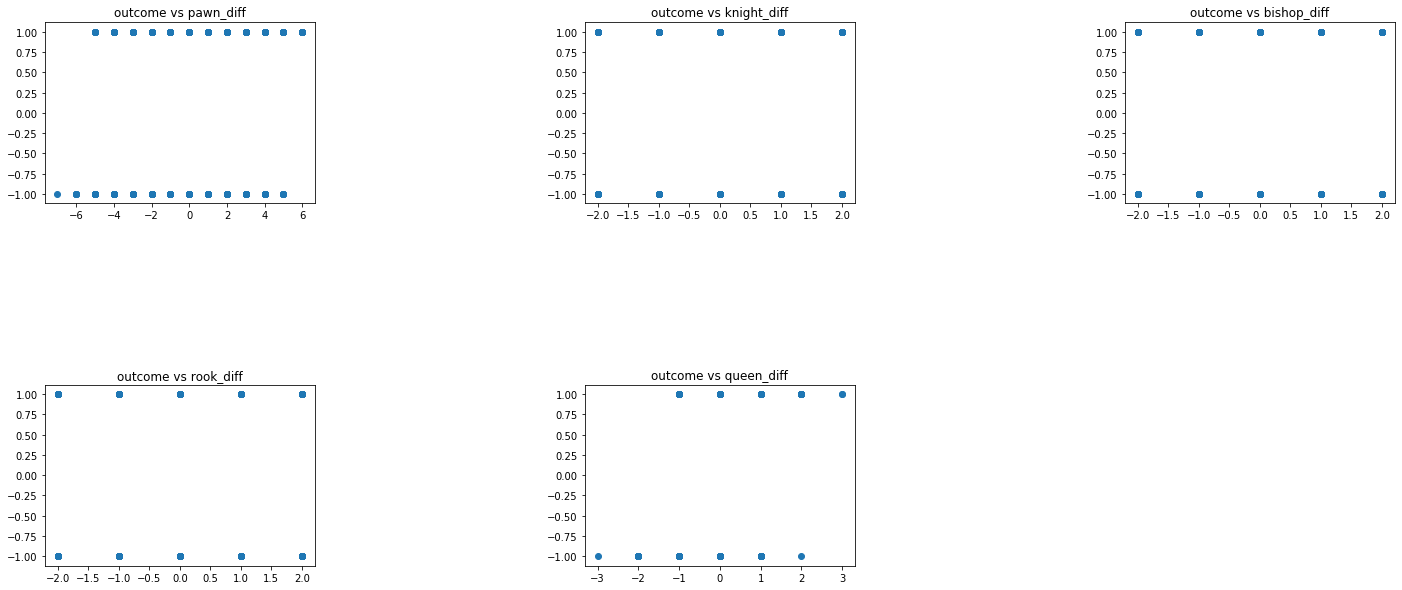

In [50]:
# make also a pandas dataframe
XY = np.hstack( (X, Y.reshape((len(Y), -1))) )
dataset = pd.DataFrame(XY, columns = dset_names)

# adjust spacing between subplots
plt.figure(figsize = (10, 10))
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=1, hspace=1)

for i in range(len(dset_names) - 1):
    plt.subplot(2, 3, i + 1)
    plt.scatter(dataset[dset_names[i]], dataset[dset_names[-1]])
    plt.gca().set_title('outcome vs ' + dset_names[i])
plt.show()

In [51]:
# Split our data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3)

In [52]:
clf = linear_model.LogisticRegression()

# grid parameters to test
Cs = [0.1, 0.5, 1, 2, 5]

estimator = GridSearchCV(clf, dict(C = Cs), cv=5, scoring='accuracy', n_jobs=-1)

# fit model
estimator.fit(Xtrain, Ytrain)
Ypred = estimator.predict(Xtest)

print('model trained')

model trained


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
# peformance on training set
Ypred = estimator.predict(Xtrain)
acc_train = accuracy_score(Ypred, Ytrain)

# peformance on test set
Ypred = estimator.predict(Xtest)
acc_test = accuracy_score(Ypred, Ytest)

# print results
print('Performance on training set: ', 'acc = ', acc_train)
print('Performance on test set: ', 'acc = ', acc_test)

Performance on training set:  acc =  0.6838145587637251
Performance on test set:  acc =  0.6968690702087287


In [54]:
# get feature weights
print('feature names: ', dset_names[:-1])
# get logistic weights
w = estimator.best_estimator_.coef_
print('logistic weights: ', w)
w1 = w / np.abs(w[0, 0])
print('normalized logistic weights: ', w1)

feature names:  ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
logistic weights:  [[0.30921809 0.66879071 0.75345147 1.11623164 2.30845909]]
normalized logistic weights:  [[1.         2.1628447  2.43663449 3.60985228 7.46547225]]


We see that the values for the rook and the queen have increased now.

We can check again the rule’s performance:

In [56]:
# calc scores with rule of thumb
scores = 1 * Xtest[:, 0] + 3 * Xtest[:, 1] + 3 * Xtest[:, 2] + 5 * Xtest[:, 3] + 9 * Xtest[:, 4] 
# logistic prob
probs = 1 / (1 + np.exp(-scores))
# logistic classification
Ypred2 = probs >= 0.5
# fix also Ytest to be in [0, 1]
Ytest2 = Ytest > 0

# calc accuracy
acc_rule = accuracy_score(Ypred2, Ytest2)
print('Performance of rule on test set: ', 'acc = ', acc_rule)

Performance of rule on test set:  acc =  0.6971062618595826


The 1-3-3-5-9 rule gives similar results as before.

# Additional filtering

Here, we will try to do an additional filtering of our data, by selecting games with larger material imbalances. The idea is that these positions might be more characteristic, thus improving our model’s performance.

In [47]:
X, Y = utils.read_games('lichess_elite_2020-06.pgn', skip_draws = True, min_material = 3)

In [2]:
#np.savez('positions_data_eliteMin_mater_4', X = X, Y = Y)
dat = np.load('positions_data_eliteMin_mater_4.npz')
X = dat['X']
Y = dat['Y']

In [4]:
# data characteristics
target_col = 5
dset_names = ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff', 'outcome']
print('Number of samples in dataset:', len(Y))
print('Input attributes:', dset_names[:target_col])
print('Target attribute:', dset_names[target_col])

print('sample inputs:')
print(X[:5])

print('sample outputs:')
print(Y[:5])

Number of samples in dataset: 2753
Input attributes: ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
Target attribute: outcome
sample inputs:
[[-2  0  2  0 -1]
 [ 2  1 -1  0  0]
 [ 2  1  0 -1  0]
 [-1 -2  2  0  0]
 [-1 -2  2 -1  0]]
sample outputs:
[-1 -1  1  1  1]


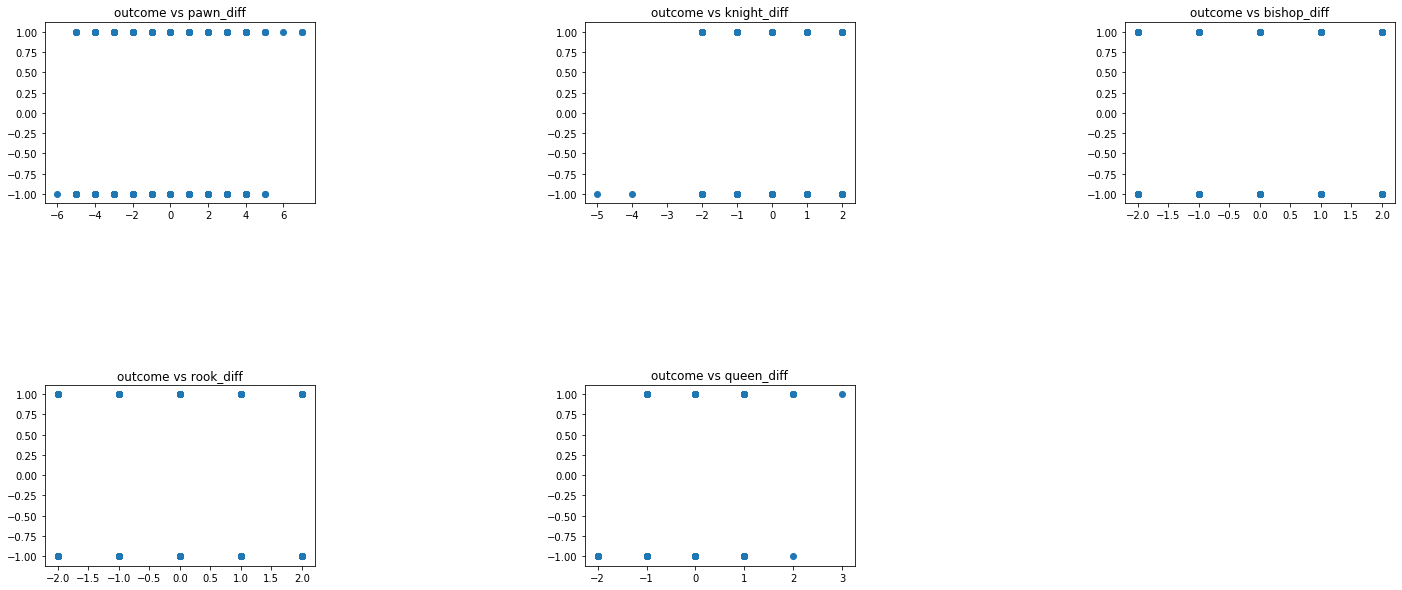

In [5]:
# make also a pandas dataframe
XY = np.hstack( (X, Y.reshape((len(Y), -1))) )
dataset = pd.DataFrame(XY, columns = dset_names)

# adjust spacing between subplots
plt.figure(figsize = (10, 10))
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=1, hspace=1)

for i in range(len(dset_names) - 1):
    plt.subplot(2, 3, i + 1)
    plt.scatter(dataset[dset_names[i]], dataset[dset_names[-1]])
    plt.gca().set_title('outcome vs ' + dset_names[i])
plt.show()

In [6]:
# Split our data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3)

In [7]:
clf = linear_model.LogisticRegression()

# grid parameters to test
Cs = [0.1, 0.5, 1, 2, 5]

estimator = GridSearchCV(clf, dict(C = Cs), cv=5, scoring='accuracy', n_jobs=-1)

# fit model
estimator.fit(Xtrain, Ytrain)
Ypred = estimator.predict(Xtest)

print('model trained')

model trained


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
# peformance on training set
Ypred = estimator.predict(Xtrain)
acc_train = accuracy_score(Ypred, Ytrain)

# peformance on test set
Ypred = estimator.predict(Xtest)
acc_test = accuracy_score(Ypred, Ytest)

# print results
print('Performance on training set: ', 'acc = ', acc_train)
print('Performance on test set: ', 'acc = ', acc_test)

Performance on training set:  acc =  0.6964193046185781
Performance on test set:  acc =  0.6840193704600485


In [9]:
# get feature weights
print('feature names: ', dset_names[:-1])
# get logistic weights
w = estimator.best_estimator_.coef_
print('logistic weights: ', w)
w1 = w / np.abs(w[0, 0])
print('normalized logistic weights: ', w1)

feature names:  ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
logistic weights:  [[0.31305152 0.65891799 0.82113033 1.0868021  2.2529833 ]]
normalized logistic weights:  [[1.         2.10482288 2.62298789 3.47163979 7.19684521]]


Our additional filtering didn’t give us different results. A potential issue we didn’t consider is that a position might be good, but a mistake is done later and “ruins it”. But for strong players, the probability of such a thing should be lower.

# Classification vs Regression

So far, we have treated the situation as a classification problem. But another possibility (not entirely correct, but OK..) is to view it as a regression problem: Namely, the piece values (features) are used to regress the game’s outcome (+1 for white’s win, -1 for loss, etc.). The weights of the regression model will again represent the importance of each feature. Let’s test this and train a regression model:  

In [10]:
reg = linear_model.LinearRegression()

reg.fit(Xtrain, Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# peformance on training set
Ypred = reg.predict(Xtrain)
mse_train = mean_squared_error(Ypred, Ytrain)

# peformance on test set
Ypred = reg.predict(Xtest)
mse_test = mean_squared_error(Ypred, Ytest)

# print results
print('Performance on training set: ', 'MSE = ', mse_train)
print('Performance on test set: ', 'MSE = ', mse_test)

Performance on training set:  MSE =  0.8282500779442904
Performance on test set:  MSE =  0.8421140669686357


In [15]:
# get feature weights
print('feature names: ', dset_names[:-1])
# get logistic weights
w = estimator.best_estimator_.coef_
print('regression weights: ', w)
w1 = w / np.abs(w[0, 0])
print('normalized weights: ', w1)

feature names:  ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
regression weights:  [[0.31305152 0.65891799 0.82113033 1.0868021  2.2529833 ]]
normalized weights:  [[1.         2.10482288 2.62298789 3.47163979 7.19684521]]


We see that the features have similar values as before.

Additionally, we can interpret the 1-3-3-5-9 rule as regression, and measure its MSE loss!

In [22]:
# calc scores with rule of thumb
scores = 1 * Xtest[:, 0] + 3 * Xtest[:, 1] + 3 * Xtest[:, 2] + 5 * Xtest[:, 3] + 9 * Xtest[:, 4] 
scores = scores / (1+3+3+5+9) # normalize scores

# calc mse
mse_rule = mean_squared_error(scores, Ytest)
print('Performance of rule on test set: ', 'mse = ', mse_rule)

Performance of rule on test set:  mse =  0.8781165412088968


The piece values are again similar as before.

### Elastic Net

Finally, let’s try to train an elastic net, which is a linear model with L1 and L2 regularization parameters. Running it on the strong players dataset, we get: 

In [23]:
reg = linear_model.ElasticNet()

# grid parameters to test
alphas = [0.01, 0.1, 0.5, 1, 2, 5]
l1_ratios = [0.1, 0.2, 0.5, 0.7, 1]

estimator = GridSearchCV(reg, dict(alpha = alphas, l1_ratio = l1_ratios), cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# fit model
estimator.fit(Xtrain, Ytrain)
Ypred = estimator.predict(Xtest)

print('model trained')

model trained


In [24]:
# peformance on training set
Ypred = estimator.predict(Xtrain)
mse_train = mean_squared_error(Ypred, Ytrain)

# peformance on test set
Ypred = estimator.predict(Xtest)
mse_test = mean_squared_error(Ypred, Ytest)

# print results
print('Performance on training set: ', 'MSE = ', mse_train)
print('Performance on test set: ', 'MSE = ', mse_test)

Performance on training set:  MSE =  0.8290297169389315
Performance on test set:  MSE =  0.8413179515242228


In [26]:
# get feature weights
print('feature names: ', dset_names[:-1])
# get logistic weights
w = estimator.best_estimator_.coef_
print('regression weights: ', w)
w1 = w / w[0]
print('normalized weights: ', w1)

feature names:  ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
regression weights:  [0.12345303 0.21017073 0.27979342 0.36210048 0.73572539]
normalized weights:  [1.         1.70243469 2.26639568 2.93310315 5.95955698]


Now, piece values are a little lower, which is reasonable due to the use of regularization. But in each case, the predictive power of material is not very high, because we lose the very important information of position. Moreover, there is also the issue that a position might be good now, but ruined on the process. A solution to mitigate this would be the use of Reinforcement Learning, where the correct value function will be attributed to each position. 

# Application on chess variants

Apart from standard chess, there are also various chess variants, each with its own weird rules and objectives! You can find out more about them here: https://en.wikipedia.org/wiki/Chess_variant
In this section, we apply our model and try to learn piece values for some of them!

# Antichess

Antichess is a chess variant where the player has to lose all his pieces first in order to win! Pieces move in exactly the same way as in standard chess, but with two differences:

1. If a player can capture one of the opponent’s pieces in a given position, he is forced to do so.
2. The king here is merely another piece: losing it doesn’t cost you the game.

You can find more information about Antichess here: https://en.wikipedia.org/wiki/Losing_chess 

To start, download and unzip the data from here: https://database.lichess.org/#variant_games/lichess_db_antichess_rated_2016-05.pgn.bz2

Now, we can collect positions and do the same analysis as before:

In [ ]:
X, Y = utils.read_games_variant('lichess_db_antichess_rated_2016-05.pgn', variant = 'antichess', skip_draws = True)

In [12]:
# np.savez('positions_data_anti', X = X, Y = Y)
dat = np.load('positions_data_anti.npz')
X = dat['X']
Y = dat['Y']

In [13]:
# data characteristics
target_col = 6
dset_names = ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff', 'king_diff', 'outcome']
print('Number of samples in dataset:', len(Y))
print('Input attributes:', dset_names[:target_col])
print('Target attribute:', dset_names[target_col])

print('sample inputs:')
print(X[:6])

print('sample outputs:')
print(Y[:5])

Number of samples in dataset: 11882
Input attributes: ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff', 'king_diff']
Target attribute: outcome
sample inputs:
[[-1 -1  0  0  0  0]
 [-1 -1  0  0  0  0]
 [ 0 -1  1 -1  0  1]
 [ 1  0  0 -1  0  1]
 [ 2  0  0  0  0  0]
 [ 0  0  0 -1  0  1]]
sample outputs:
[ 1  1 -1 -1 -1]


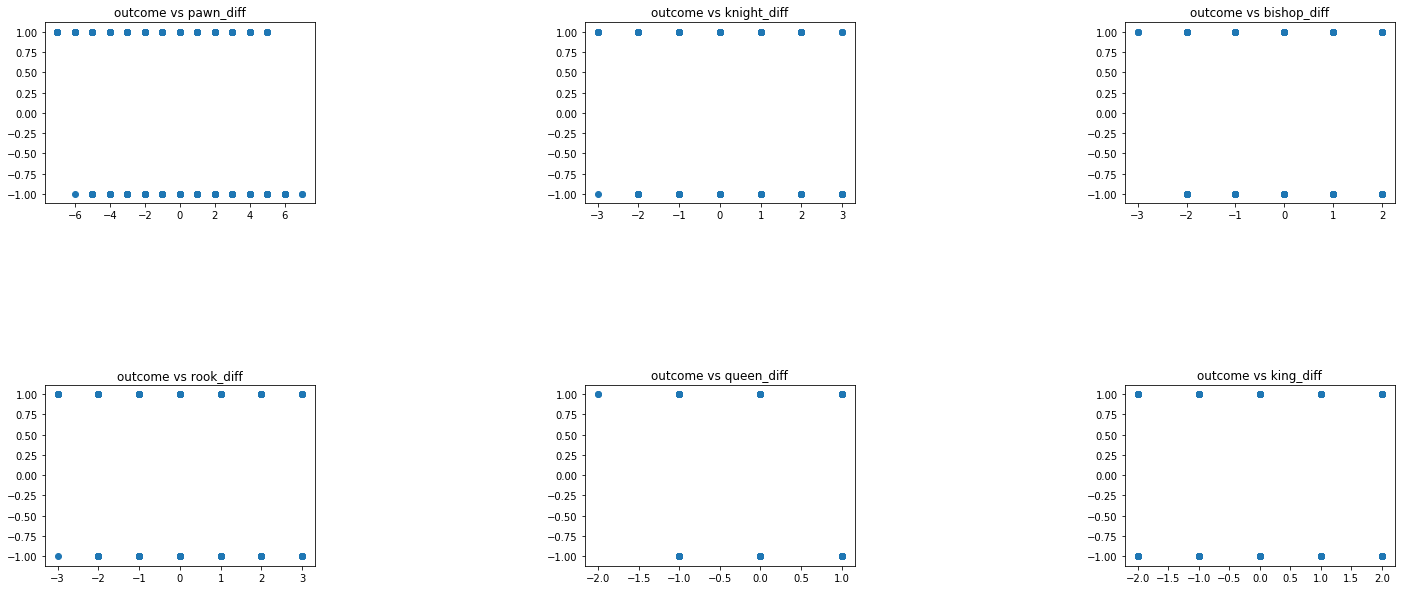

In [15]:
# make also a pandas dataframe
XY = np.hstack( (X, Y.reshape((len(Y), -1))) )
dataset = pd.DataFrame(XY, columns = dset_names)

# adjust spacing between subplots
plt.figure(figsize = (10, 10))
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=1, hspace=1)

for i in range(len(dset_names) - 1):
    plt.subplot(2, 3, i + 1)
    plt.scatter(dataset[dset_names[i]], dataset[dset_names[-1]])
    plt.gca().set_title('outcome vs ' + dset_names[i])
plt.show()

In [14]:
# Split our data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3)

In [16]:
clf = linear_model.LogisticRegression()

# grid parameters to test
Cs = [0.1, 0.5, 1, 2, 5]

estimator = GridSearchCV(clf, dict(C = Cs), cv=5, scoring='accuracy', n_jobs=-1)

# fit model
estimator.fit(Xtrain, Ytrain)
Ypred = estimator.predict(Xtest)

print('model trained')

model trained


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
# peformance on training set
Ypred = estimator.predict(Xtrain)
acc_train = accuracy_score(Ypred, Ytrain)

# peformance on test set
Ypred = estimator.predict(Xtest)
acc_test = accuracy_score(Ypred, Ytest)

# print results
print('Performance on training set: ', 'acc = ', acc_train)
print('Performance on test set: ', 'acc = ', acc_test)

Performance on training set:  acc =  0.6659853312492485
Performance on test set:  acc =  0.647124824684432


In [19]:
# get feature weights
print('feature names: ', dset_names[:-1])
# get logistic weights
w = estimator.best_estimator_.coef_
print('logistic weights: ', w)
w1 = w / np.abs(w[0, 0])
print('normalized logistic weights: ', w1)

feature names:  ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff', 'king_diff']
logistic weights:  [[-0.29280669 -0.31590648 -0.4480301  -0.40612974 -0.39169166 -0.05741419]]
normalized logistic weights:  [[-1.         -1.07889093 -1.5301225  -1.38702342 -1.33771418 -0.19608223]]


We see that we can get an estimate of piece values for other chess variants too! In this case, we 1st see that the weights are negative, which is expected: if we have more material in antichess then we’re most likely losing, since we must lose it all to win! Further, we see that the differences in piece values are smaller now, and that the worst piece to have is the bishop. This is indeed true! In antichess, its very common to get trapped into positions where your bishop is forced to “take everything” and lose the game!

# Atomic

Another funny chess variant is the so-called Atomic chess! Here, pieces move as in normal chess, but if a piece captures another, they explode! More specifically, we have:

1. If a piece captures another, they both go out of the game.
2. Moreover, all pieces on the 3x3 region around the “explosion” go out as well – apart from pawns!
3. The king can explode too! We can win not only with checkmate, but also by exploding the opponent’s king!

For more information on Atomic, see this link: https://en.wikipedia.org/wiki/Atomic_chess 

First, lets download and unzip some atomic games from here: https://database.lichess.org/#variant_games/lichess_db_atomic_rated_2018-05.pgn.bz2

Now, we collect game positions and do the same analysis as before:

In [ ]:
X, Y = utils.read_games_variant('lichess_db_atomic_rated_2018-05.pgn', variant = 'atomic', skip_draws = True)

In [1]:
np.savez('positions_data_atomic', X = X, Y = Y)
#dat = np.load('positions_data_atomic.npz')
#X = dat['X']
#Y = dat['Y']

NameError: name 'np' is not defined

In [22]:
# data characteristics
target_col = 5
dset_names = ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff', 'outcome']
print('Number of samples in dataset:', len(Y))
print('Input attributes:', dset_names[:target_col])
print('Target attribute:', dset_names[target_col])

print('sample inputs:')
print(X[:5])

print('sample outputs:')
print(Y[:5])

Number of samples in dataset: 7518
Input attributes: ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
Target attribute: outcome
sample inputs:
[[ 1 -1  0  0  1]
 [ 1 -1  0  0  1]
 [ 1 -1  0  0  1]
 [ 2 -2  0  0  0]
 [ 3 -1  1  0  0]]
sample outputs:
[1 1 1 1 1]


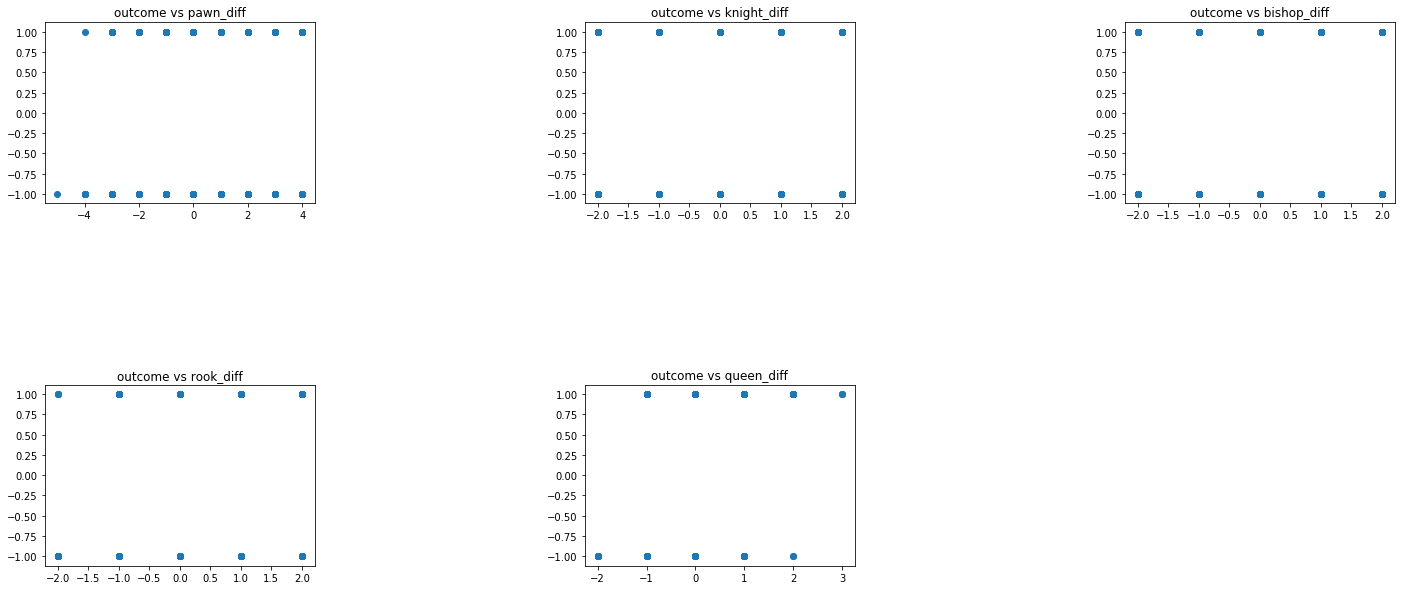

In [23]:
# make also a pandas dataframe
XY = np.hstack( (X, Y.reshape((len(Y), -1))) )
dataset = pd.DataFrame(XY, columns = dset_names)

# adjust spacing between subplots
plt.figure(figsize = (10, 10))
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=1, hspace=1)

for i in range(len(dset_names) - 1):
    plt.subplot(2, 3, i + 1)
    plt.scatter(dataset[dset_names[i]], dataset[dset_names[-1]])
    plt.gca().set_title('outcome vs ' + dset_names[i])
plt.show()

In [24]:
# Split our data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3)

In [25]:
clf = linear_model.LogisticRegression()

# grid parameters to test
Cs = [0.1, 0.5, 1, 2, 5]

estimator = GridSearchCV(clf, dict(C = Cs), cv=5, scoring='accuracy', n_jobs=-1)

# fit model
estimator.fit(Xtrain, Ytrain)
Ypred = estimator.predict(Xtest)

print('model trained')

model trained


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
# peformance on training set
Ypred = estimator.predict(Xtrain)
acc_train = accuracy_score(Ypred, Ytrain)

# peformance on test set
Ypred = estimator.predict(Xtest)
acc_test = accuracy_score(Ypred, Ytest)

# print results
print('Performance on training set: ', 'acc = ', acc_train)
print('Performance on test set: ', 'acc = ', acc_test)

Performance on training set:  acc =  0.6269479285442797
Performance on test set:  acc =  0.675531914893617


In [27]:
# get feature weights
print('feature names: ', dset_names[:-1])
# get logistic weights
w = estimator.best_estimator_.coef_
print('logistic weights: ', w)
w1 = w / np.abs(w[0, 0])
print('normalized logistic weights: ', w1)

feature names:  ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
logistic weights:  [[0.16197727 0.13632543 0.27341512 0.55372952 0.91646594]]
normalized logistic weights:  [[1.         0.84163308 1.68798454 3.41856317 5.65799113]]


For atomic, we see that the relative value of pawns is larger than in standard chess. This is reasonable, since pawns are not affected by explosions, and thus have an additional advantage in this variant. 

Some strong atomic players have suggested the following piece values: pawn = 1, knight = bishop = 1.5, rook = 3, queen = 6. We  can again test the accuracy of this “1-1.5-1.5-3-6” rule:

In [28]:
# calc scores with rule of thumb
scores = 1 * Xtest[:, 0] + 1.5 * Xtest[:, 1] + 1.5 * Xtest[:, 2] + 3 * Xtest[:, 3] + 6 * Xtest[:, 4] 
# logistic prob
probs = 1 / (1 + np.exp(-scores))
# logistic classification
Ypred2 = probs >= 0.5
# fix also Ytest to be in [0, 1]
Ytest2 = Ytest > 0

# calc accuracy
acc_rule = accuracy_score(Ypred2, Ytest2)
print('Performance of rule on test set: ', 'acc = ', acc_rule)

Performance of rule on test set:  acc =  0.6436170212765957


The rule’s accuracy is similar to our model. Moreover, the values our model found this time are very close to the atomic rule, with the exception of the knight’s value, which is a bit reduced. We believe that the reason for this is that we have filtered out games with a very small number of moves, where a player can easily win his opponent in Atomic, if the opponent is not so prepared, and doesn’t know how to properly defend against the knight attacks. These attacks happen usually in the beginning of the game, and thus, by filtering, we have somewhat reduced the knight’s calculated value. Finally, in atomic it’s very easy to make a mistake and lose, and this can also affect the model’s predictions. 

## Reinforcement Learning?

This is a speculative experiment, and not so easy to understand. Feel free to ignore it!

As we saw previously, an issue with the supervised learning method is that a position might be good now, but “get ruined” later by a player’s mistake. So, a good position can lead to a bad one, and visa versa. A supervised model doesn’t know which one contributed to the game’s outcome, and thus can be mislead. 

To mitigate this, our piece values will now try to predict not the final outcome of the game, but the value function of each given position. The value function tells us the probability of winning starting from this position, and is found by Reinforcement Learning. As such, it’s a better measure for a position’s goodness, and that might help our model.

Here, we won’t play games from scratch. Instead, we will assume that our Master games are produced from a common (stochastic) Master policy $π$, which is supposed to be the way that a professional chess player plays. We will then try to learn the value function of that policy, by sampling from the Master’s games. We use TD(0) learning, where the value function $V(s)$ of a given state (position) tries to approximate the value function of he next state, $R + V(s')$, where $R$ is the reward (which is given at the end of the game in chess, and is zero elsewhere). 

We don’t have to run TD learning iteratively, since one can show that the weights we want to find in the linear case are the solution of the system: $E[(R + γv(s') - v(s))^2]$, where $E$ is the mean value, and $v(s) = w^T \cdot s$ is the linear value function approximation we want to find.  

So, let’s sample some game positions, along with their subsequent positions and rewards:

In [ ]:
# X: current pos, Xn: next pos, R: rewards
X, Xn, R = read_games_rl('lichess_elite_2020-06.pgn')

In [3]:
#np.savez('data_elite_rl', X = X, Xn = Xn, R = R)
dat = np.load('data_elite_rl.npz')
X = dat['X']
Xn = dat['Xn']
R = dat['R']

In [4]:
# print sample data
target_col = 5
dset_names = ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
print('Number of samples in dataset:', len(R))

print('sample states:')
print(X[:5])

print('sample next states:')
print(Xn[:5])

print('sample rewards:')
print(R[:5])

Number of samples in dataset: 60012
sample states:
[[ 0 -1  0  0  0]
 [ 0 -1  1  0  0]
 [ 1 -1  0  0  0]
 [ 1 -1  1  0  0]
 [ 1 -1  1  0  0]]
sample next states:
[[ 0 -1  0  0  0  0]
 [ 0 -1  1  0  0  0]
 [ 1 -1  0  0  0  0]
 [ 1 -1  1  0  0  0]
 [ 1 -1  1  0  0  0]]
sample rewards:
[0 0 0 0 0]


We observe that in most transitions the state doesn’t change (no captures), and the reward is zero.

Now, the solution of the system stated above is equivalent to the following linear regression: $w^T (v(s) - γv(s')) \rightarrow R(s)$. We formulate the problem in this way and train our model. We also select $γ = 0.99$ as the discount factor. We get:

In [11]:
gamma = 0.99

reg = linear_model.LinearRegression()

Xi = gamma * Xn - X
reg.fit(Xi, R)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
# get feature weights
print('feature names: ', dset_names)
# get logistic weights
w = reg.coef_
print('regression weights: ', w)
w1 = w / w[0]
print('normalized weights: ', w1)

feature names:  ['pawn_diff', 'knight_diff', 'bishop_diff', 'rook_diff', 'queen_diff']
regression weights:  [0.75264309 0.94341921 0.92572296 0.8651051  1.11907679]
normalized weights:  [1.         1.25347488 1.22996275 1.14942276 1.48686251]


We see that the obtained values are very bad! This is due to various factors, such as bad or not enough sampling, many identical states, etc. Moreover, the assumption that all games come from a commin policy is of course wrong! 

# Conclusion

In this notebook, we tried to explain the chess piece values and the corresponding rule under a machine learning light: namely, the pieces are predictors / features of a games outcome, and their values are the weights of these features. This could give us reasonable values for standard chess and some of its variants. It’s worthwhile to try and further improve these results, and see how close to the rule values one can get. 

Finally, we hope you had fun!   